<a href="https://colab.research.google.com/github/Hank-Cui/KWHS2019/blob/master/Simple_LSTM_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import clear_output

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
comp_tic = "GOOG"
days = 3650
df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
df["Date"] = df.Date.astype(np.datetime64)
df.sort_values(by=["Date"], inplace = True)
df.set_index('Date', inplace = True)
df = df[-days:]
df = df.drop(columns=["Dividends", "Stock Splits","Volume"])
df.tail()

,Open,High,Low,Close
Date,,,,
2019-10-11,1222.209961,1228.390015,1213.739990,1215.449951
2019-10-14,1212.339966,1226.329956,1211.760010,1217.140015
2019-10-15,1220.400024,1247.329956,1220.400024,1243.010010
2019-10-16,1241.170044,1254.739990,1238.449951,1243.640015
2019-10-17,1250.930054,1263.324951,1249.939941,1253.069946


**Keras**

In [0]:
from sklearn.preprocessing import MinMaxScaler

dataset = df["Close"].values.reshape(-1, 1)
# training_set = dataset_train.iloc[:, 3:4].values  # Take close price

# training_set_ = dataset_train[:, 1:2].values

sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)

print(dataset_scaled)

[[0.        ]
 [0.0025642 ]
 [0.00742025]
 ...
 [0.96251161]
 [0.96304151]
 [0.97097316]]


In [0]:
X_data = []
y_data = []
interval = 60

for i in range(interval, len(dataset_scaled)-10):
    X_data.append(dataset_scaled[i-interval:i, 0])
    y_data.append(dataset_scaled[i:i+10, 0])
X_data, y_data = np.array(X_data), np.array(y_data)  # Convert to numpy

X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], -1)  # Add a dimension
# y_data = y_data.reshape(y_data.shape[0], y_data.shape[1], -1)  # Add a dimension

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, shuffle=False)

X_train, y_train = X_data, y_data

In [0]:
# !pip install --upgrade tensorflow
!pip install keras-tqdm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras_tqdm import TQDMNotebookCallback
clear_output()

In [0]:
regressor = Sequential()

regressor.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 256, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 256, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 256))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 10))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (None, 60, 256)           264192    
_________________________________________________________________
dropout_101 (Dropout)        (None, 60, 256)           0         
_________________________________________________________________
lstm_102 (LSTM)              (None, 60, 256)           525312    
_________________________________________________________________
dropout_102 (Dropout)        (None, 60, 256)           0         
_________________________________________________________________
lstm_103 (LSTM)              (None, 60, 256)           525312    
_________________________________________________________________
dropout_103 (Dropout)        (None, 60, 256)           0         
_________________________________________________________________
lstm_104 (LSTM)              (None, 256)             

In [0]:
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32, callbacks=[TQDMNotebookCallback()])

Epoch 1/30


 960/3580 [=======>......................] - ETA: 57s - loss: 0.0363

In [0]:
y_test.shape

(307, 10)

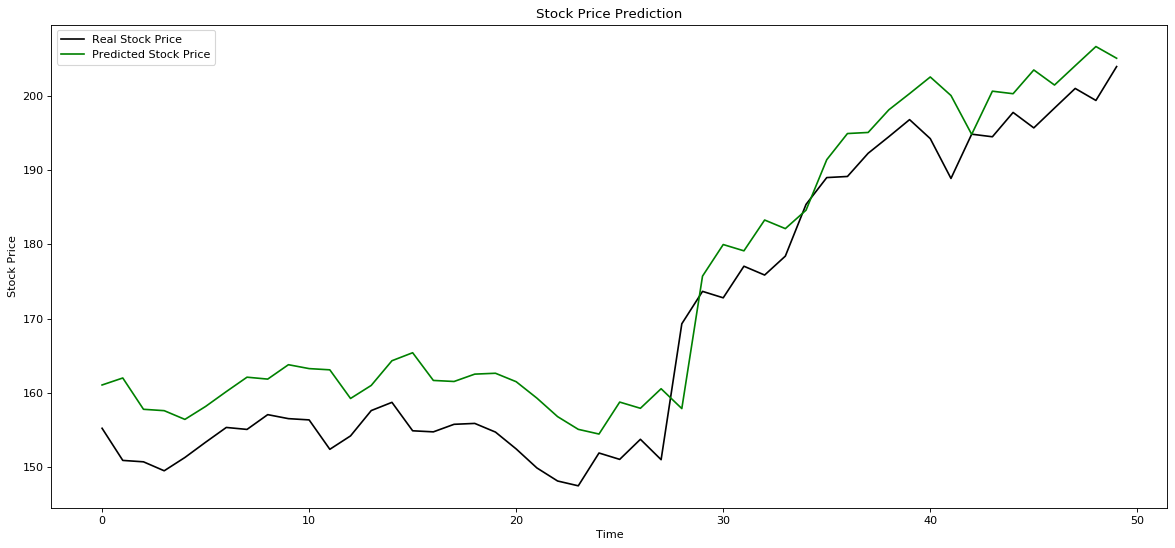

In [0]:
def show_graph(dataset, real):
    predicted_stock_price = regressor.predict(dataset)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    real_stock_price = sc.inverse_transform(real.reshape(-1, 1))

    plt.figure(figsize=(18, 8), dpi=80)
    plt.plot(real_stock_price[100:150], color = 'black', label = 'Real Stock Price')
    plt.plot(predicted_stock_price[100:150], color = 'green', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

show_graph(X_train, y_train)

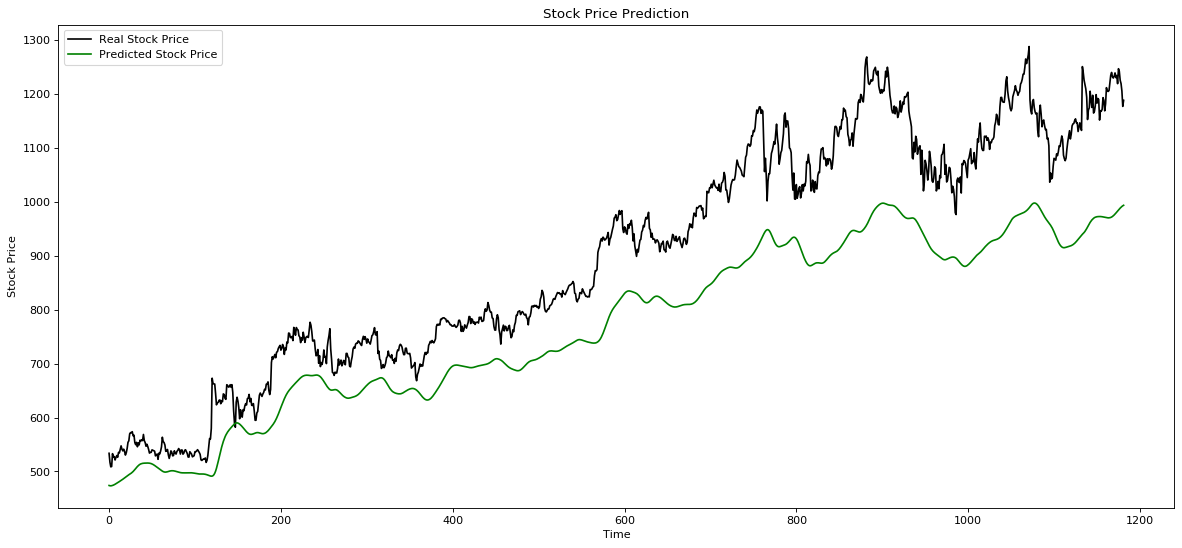

In [0]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# inputs = inputs.reshape(-1,1)
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(60, 76):
#     X_test.append(inputs[i-60:i, 0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

x=90

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(y_test[:, 0].reshape(-1, 1))

plt.figure(figsize=(18, 8), dpi=80)
plt.plot(real_stock_price[:], color = 'black', label = 'Real Stock Price')
plt.plot(predicted_stock_price[:, 0], color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Pytorch**

In [0]:
x_data = df
y_data = df["Close"].shift(-1)
x_data = x_data.values
y_data = y_data.values

n_steps = 21
x, y = [],[]
length = x_data.shape[0]
for i in range(length):
    end_index = i + n_steps

    if(end_index >= length):
        break;
        
    x.append(x_data[i:end_index]) 
    y.append(y_data[end_index])

x = np.array(x)
y = np.array(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, shuffle=False)

X_train = torch.tensor(X_train.reshape(X_train.shape[0], -1, X_train.shape[1]))
X_test = torch.tensor(X_test.reshape(X_test.shape[0], -1, X_test.shape[1]))
y_train = torch.tensor(y_train.reshape(y_train.shape[0], -1, 1))
y_test = torch.tensor(y_test.reshape(y_test.shape[0], -1, 1))

device = torch.device("cuda:0")
x_train = X_train.to(device, dtype=torch.float)
y_train = y_train.to(device, dtype=torch.float)

In [0]:
print(x_train.shape)
print(y_train.shape)

torch.Size([342, 21, 4])
torch.Size([342, 1, 1])


In [0]:
x = torch.tensor(x[:-1].reshape((x.shape[0])-1, -1, 4))
y = torch.tensor(y[:-1].reshape((y.shape[0])-1, 1, -1))

device = torch.device("cuda:0")
x_train = x.to(device, dtype=torch.float)
y_train = y.to(device, dtype=torch.float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [0]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(input_size, hidden_dim, 2,
                          dropout=1)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, dropout=1)
        # self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_size)
        # self.linear3 = nn.Linear(hidden_dim, output_size)

    def forward(self, input):
        x, _ = self.gru(input)
        x = torch.relu(x)
        x, _ = self.lstm(x)
        # x, _ = self.lstm2(x)
        x = torch.relu(x)
        x = self.linear(x)
        x = self.linear2(x)
        # x = self.linear3(x)
        # x = torch.sigmoid(x)
        return x

device = torch.device("cuda:0")
lstm = LSTM(x_train.shape[2], 256, 1).to(device)
print(lstm)

LSTM(
  (gru): GRU(4, 256, num_layers=2, dropout=1.0)
  (lstm): LSTM(256, 256, dropout=1.0)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.03)

for epoch in range(30000):
    lstm.zero_grad()
    output = lstm(x_train)
    loss = criterion(output, y_train)
    if (epoch%50==0): print(loss)
    # if (epoch%500==0): show_fig()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([342, 1, 1])) that is different to the input size (torch.Size([342, 21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(70430.0938, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(452.0846, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.6296, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.5378, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.5324, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.5317, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.5306, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.5277, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.4413, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.2469, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(430.6943, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(439.4916, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.0473, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(468.9993, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(431.8116, device='cuda:0', grad_fn=<MseLossBackward>)


KeyboardInterrupt: ignored

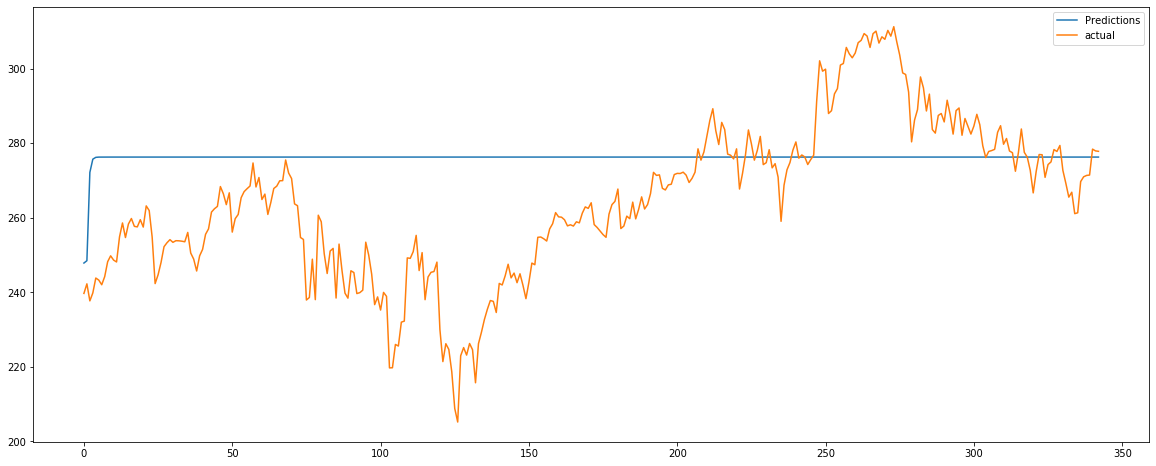

In [0]:
show_fig()

In [0]:
def show_fig():
    pred = lstm(x_train)

    plt.figure(figsize=(20,8))
    plt.plot(pred.cpu().detach()[:,3,:], label='Predictions')
    plt.plot(y_train.cpu().detach().flatten(), label='actual')
    plt.legend()
    plt.show()


# x_test = X_test.to(device, dtype=torch.float)

# pred = lstm(x_test)

# plt.figure(figsize=(20,5))
# plt.plot(pred.cpu().detach().flatten(), label='Predictions')
# #plt.plot(test_y.flatten()[2:], label='actual')
# plt.plot(y_test.flatten(), label='actual')
# plt.legend()
# plt.show()